NON linear BVP:

      - div( mu(u) * grad(u) ) + w * grad(u) = f  in domain
                                           u = g  on bdry dirichlet
                          - mu(u) nabla(u).n = 0 on bdry Neumann
    with w: given velocity field; mu: given diffusivity coeff. 
    
Example of basic exact solution in domain=(0,1)^2: 

        u = sin(x[0]) + sin(x[1]) corresponds to: 
        f = cos(x[0]) + cos(x[1]) + sin(x[0]) + sin(x[1]) and g = sin(x[0]) + sin(x[1])

In [1]:
from dolfin import *
import sys
from sys import exit
import numpy as np 
import os
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# FUNCTIONS

In [2]:
# transform a npy array to a FEniCS field
def numpy_to_fenics(array, function_space):
	function = Function(function_space)
	for i in range(len(function.vector()[:])):
		function.vector()[i] = array[i]
	return function

## Dirichlet boundary conditions

The functions below return True for points inside the subdomain and False for the points outside.
Because of rounding-off errors, we specify |𝑥−1|<𝜖, where 𝜖 is a small number (such as machine precision).

In [3]:
tol_bc = 1e-7
def u_bdry_x0(x, on_boundary): # Left bdry
    return bool(on_boundary and (near(x[0], 0, tol_bc)))

def u_bdry_x1(x, on_boundary): # Right bdry
    return bool(on_boundary and (near(x[0], 1., tol_bc)))

## The non linear parameter m(u) and its derivative

In [4]:
m = 5
#print('The power-law exponent of the non linearity m = ', m)
print('The expression of mu(u) is ... see function !')
def mu(u):
    return (0.1+u)**int(m) # non linear law
    #return (1. + 1.e-30*u) # ugly way to consider an almost linear equation
    #return 1.

def dmu_du(u):
    return m * (0.1+u)**int(m-1)
    #return 1.e-30
    #return u * 0.

The expression of mu(u) is ... see function !


In [5]:
os.system("clear") 
print('#')
print('# MAIN PROGRAM')
print('#')

#
# MAIN PROGRAM
#


In [6]:
# Create mesh and function space
NP =  30; print('Number of mesh points NP = ', NP)
mesh = UnitSquareMesh(NP,NP)
k = 2 ; print('Order of the Lagrange FE k = ', k)
V = FunctionSpace(mesh, "CG", int(k)) # Lagrange FE, order k

Number of mesh points NP =  30
Order of the Lagrange FE k =  2


In [7]:
# Velocity field if advection term
advection = False # or True...
if advection:
    # Be creative ! Define your own velocity field following the instructions
    vel_amp = 1.e+2#; print('vel_amp =',vel_amp)
    vel_exp = Expression(('(1.+abs(cos(2*pi*x[0])))', 'sin(2*pi/0.2*x[0])'), element = V.ufl_element())
    V_vec = VectorFunctionSpace(mesh,"CG", k)
    vel = vel_amp * interpolate(vel_exp,V_vec)
    # plot
    p=plot(vel,title='The velocity field')
    p.set_cmap("rainbow"); plt.colorbar(p);
    plt.show()
else:
    vel_exp = Expression(('0.', '0.'), element = V.ufl_element())

In [8]:
# To transform a vector vec to a fenics object vf
# vf= Function(V); vf.vector().set_local(vec)

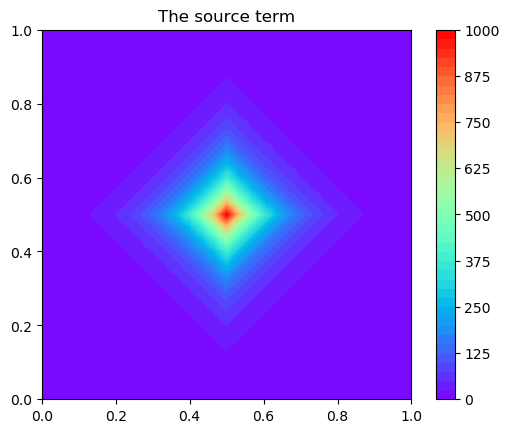

In [9]:
# The physical RHS 
#f_exp = Expression('1.', element = V.ufl_element())
fp_exp = Expression('1e+03 * exp( -( abs(x[0]-0.5) + abs(x[1]-0.5) ) / 0.1 )', element = V.ufl_element())
fp = interpolate(fp_exp,V)
#fp = Expression('0.', degree=u.ufl_element().degree())
 
p2=plot(fp,title='The source term')
p2.set_cmap("rainbow"); plt.colorbar(p2)
plt.show(block=True)

In [10]:
print('##################################################################')
print('#')
print('# Newton - Raphson algorithm: Home-implemented non linear solver :)')
print('#')
print('##################################################################')

print('#')
print('# Initialization: u0 solution of a semi-linearized BVP')
print('#')

##################################################################
#
# Newton - Raphson algorithm: Home-implemented non linear solver :)
#
##################################################################
#
# Initialization: u0 solution of a semi-linearized BVP
#


# Trial & Test functions

In [11]:
# Trial & Test functions
u = TrialFunction(V); v = TestFunction(V)

# Condition de Dirichlet
u_diri_non_homo = Expression('1.', degree=u.ufl_element().degree())
u_diri_homo = Expression('0.', degree=u.ufl_element().degree())
bc = DirichletBC(V, u_diri_non_homo, u_bdry_x0)

In [12]:
# Coef diffusion
u0_mu_exp = Expression('0.', element=V.ufl_element())
mu0 = mu( interpolate(u0_mu_exp, V))

In [13]:
# Problème semi-linéarisé pour trouver u0
if advection:
    F0 = dot(mu0 * grad(u),grad(v)) * dx + dot(vel, grad(u)) * v * dx - fp * v * dx
    # Add the SUPG stabilisation terms
    vnorm = sqrt( dot(vel, vel) )
    h = MaxCellEdgeLength(mesh)
    delta = h / (2.0*vnorm)
    residual = - div(mu0 * grad(u) ) + dot(vel, grad(u)) - fp  # the residual expression
    F0 += delta * residual * dot(vel, grad(v)) * dx # the enriched weak formulation
else:
    F0 = dot(mu0*grad(u), grad(v)) * dx - fp *v * dx

In [14]:
a0 = lhs(F0); L0 = rhs(F0)

In [15]:
# Neumann bc
# Nothing to do since they are here homogeneous !
# F0 += int-de-bord

# Solve the linear system
u0 = Function(V)
solve(a0 == L0, u0, bc)# , [bc0,bc1])z

Solving linear variational problem.


In [16]:
if advection:
        # Peclet number(s)
        Pe = 0.5 * sqrt(dot(vel, vel))/ mu0
        Pe_np = project(Pe,V).vector().get_local()
        hmax=mesh.hmax(); #print(type(hmax))
        Peh_np = hmax * Pe_np
        print('Peclet number Pe: approx. (min., max.) values for u0 : ', '{0:.2f}'.format(Pe_np.min()), '{0:.2f}'.format(Pe_np.max()))
        print('Num. Peclet number Pe_h=(h.Pe): approx. (min., max.) values for u0 : ', '{0:.2f}'.format(Peh_np.min()), '{0:.2f}'.format(Peh_np.max()))
        ans = print("   press any key to resume...")

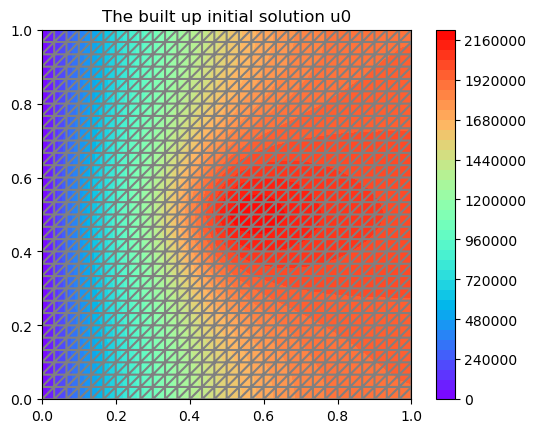

In [17]:
# Plot the solution
plt.figure(); plot(mesh)
p=plot(u0, title='The built up initial solution u0')
p.set_cmap("rainbow"); plt.colorbar(p)
plt.show(block=False)

In [18]:
print('#')
print('# Iterations')
print('#') 
i_max = 60 # max of iterations
eps_du = 1e-9 # tolerance on the relative norm 

#
# Iterations
#


In [19]:
# The FE unknowns 
du = TrialFunction(V)
un, dun = Function(V), Function(V)
un = u0.copy() # initialisation
bc0 = DirichletBC(V, u_diri_homo, u_bdry_x0)

In [20]:
a = inner(dmu_du(un) * du * nabla_grad(un), nabla_grad(v))*dx + inner(mu(un) * nabla_grad(du), nabla_grad(v))*dx
L = fp * v * dx - inner(mu(un) * nabla_grad(un) , nabla_grad(v)) * dx

In [21]:
# Loop
i = 0
error = 1. # current iteration
while (error>eps_du and i<i_max): 
    i+=1 # update the current iteration number
    print("Newton-Raphson iteration #",i," begins...")

    # mu and dmu_du at the current iteration
    mu_n = mu(un)
    dmu_du_n = dmu_du(un)
    if advection:
         # LHS of the linearized variational formulation
         a = inner( mu_n*grad(du) , grad(v) ) * dx + inner(vel, grad(du)) * v * dx + inner(dmu_du_n*du *grad(un) , grad(v)) * dx
         # RHS of the linearized eqn
         Lan = inner(mu_n*grad(un) , grad(v)) * dx  + inner(vel, grad(un)) * v * dx 
         L = fp * v * dx - Lan
         
         # Add the SUPG stabilisation terms. The residual expression: residu = residu_lhs - fp
         Zero_exp=Expression('0.', element = V.ufl_element())
         #residual_lhs = -  div( mu_n*grad(du) ) + dot(vel, grad(du))
         #residual_rhs = interpolate(Zero_exp,V)  
         #print('   SUPG: residual expression of the semi-linearized eqn ...')
         residual_lhs = -  div( mu_n*grad(du) ) + dot(vel, grad(du)) - div( dmu_du_n*du * grad(un))
         residual_rhs = -  div( mu_n*grad(un) ) + dot(vel, grad(un))
         # print('   SUPG: complete residual expression of the linearized eqn :)')
    else:
        a = inner(dmu_du(un) * du * nabla_grad(un), nabla_grad(v))*dx + inner(mu(un) * nabla_grad(du), nabla_grad(v))*dx
        L = fp * v * dx - inner(mu(un) * nabla_grad(un) , nabla_grad(v)) * dx
    # Solve
    solve(a == L, dun, bc0)
    un.assign(un+dun) # update the solution

    # relative diff.
    dun_np = dun.vector().get_local()
    un_np = un.vector().get_local()
    #print(type(dun_np)) #print(dun_np.shape)
    error = np.linalg.norm(dun_np) / np.linalg.norm(un_np)
    print("Newton-Raphson iteration #",i,"; error = ", error)

    # test
    if (i == i_max and error>eps_du):
        print("Warning: the algo exits because of the max number of ite ! error = ",error)

Newton-Raphson iteration # 1  begins...
Solving linear variational problem.
Newton-Raphson iteration # 1 ; error =  0.20000001392683525
Newton-Raphson iteration # 2  begins...
Newton-Raphson iteration # 2 ; error =  0.20000001670935658
Newton-Raphson iteration # 3  begins...
Solving linear variational problem.
Solving linear variational problem.
Newton-Raphson iteration # 3 ; error =  0.20000002004443376
Newton-Raphson iteration # 4  begins...
Newton-Raphson iteration # 4 ; error =  0.2000000240559483
Newton-Raphson iteration # 5  begins...
Solving linear variational problem.
Solving linear variational problem.
Newton-Raphson iteration # 5 ; error =  0.20000002886947874
Newton-Raphson iteration # 6  begins...
Solving linear variational problem.
Newton-Raphson iteration # 6 ; error =  0.20000003464879557
Newton-Raphson iteration # 7  begins...
Newton-Raphson iteration # 7 ; error =  0.20000004157514326
Newton-Raphson iteration # 8  begins...
Solving linear variational problem.
Solving l

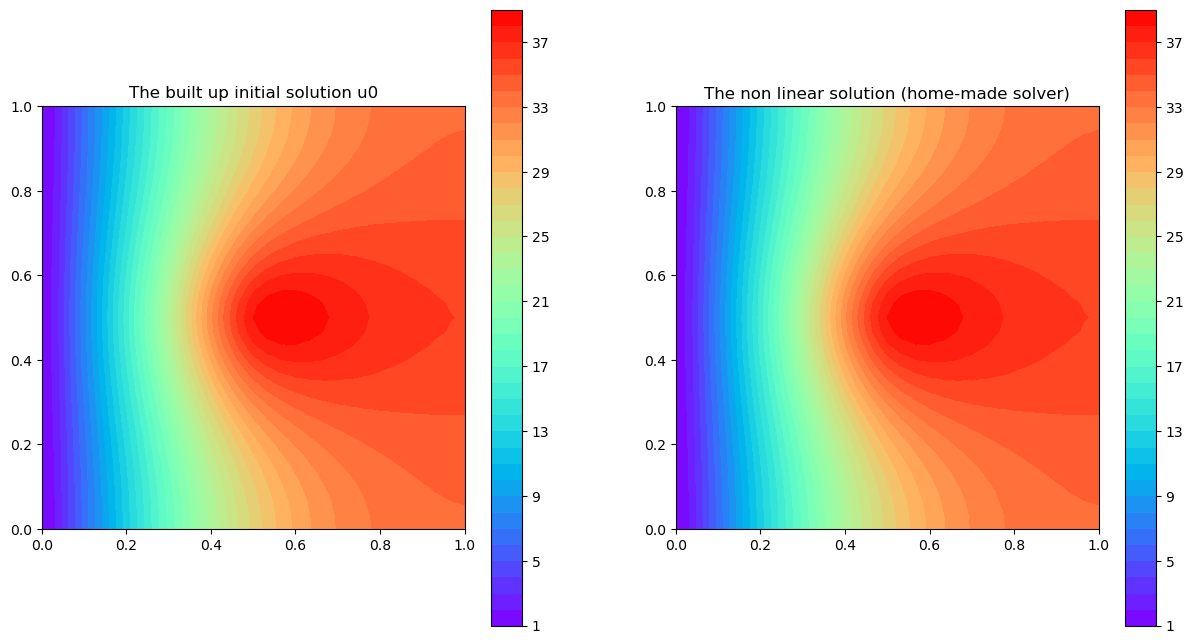

In [22]:
# Plots
#
plt.figure(1, figsize=(15,8))
plt.subplot(121)#; plot(mesh)
p=plot(u0, title='The built up initial solution u0')
p.set_cmap("rainbow"); plt.colorbar(p)
# plt.show(block=False)

plt.subplot(122);# plot(mesh)
p=plot(un, title='The non linear solution (home-made solver)')
p.set_cmap("rainbow"); plt.colorbar(p)
plt.show()